# Assignment 2.1  (OLD does not work)
This is the code for my old implementation. Id did not work.

Consider the bounddary value problem on $\Omega = [0,1]^2$: find $u$ such that
\begin{align}
    - \Delta u &= f \qquad \text{in } \Omega, \\
    u &= 0 \qquad \text{on } \partial \Omega,
\end{align}
with $f=2(x(1-x)+y(1-y))$. . 

## Initialization

In [ ]:
''' The used imports '''
# numpy is used for elongating my life expectancy and general happyness. 
import numpy as np 

# matplotlib is used for plotting those nice graphs. 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable 

# for the animations
from matplotlib import animation
from IPython.display import HTML

# for the mathematics in the hood dawgh
import scipy.sparse as sp           # for sparse objects 
import scipy.sparse.linalg as la    # for sparse calculations
import scipy.integrate as integrate # for integration 


In [ ]:
'''  System paramters ''' 

L_s = 1 # the length of the domain in one direction

k_s = 5 # number of nonoverlapping square subdomains in one direction

m_s = 5 # number of elements in each domain in one direction

l_s = 2 # extention of the nonoverlapping subdomains by l layers

## Aditional system paramtesr that might become usefull

N_s = k_s**2 # the total number of sub domains 

h_s = L_s/(k_s*m_s) # spacing for the total mesh

The function ``` create(func,nx,ny) ``` creates a lexicographically order 2D vector from a continous function $f(x,y)$ on a uniform mesh $\Delta$. 


In [ ]:
# create a 2D lexicographically orderd vector, works also for 1D fine. 

# this only works for nice domains

def create(func, Nx:int, Ny:int, L:float=L_s):
    ''' Create a lexicographical vector of a 2D mapping. Don't include () afther the function name
        
    '''
    Fvec = np.zeros((Nx)*(Ny)) # create a zero vector that is the correct form
    h = L/(Nx-1) # find h. only works now for h_x = h_y
    for j in range(Ny):
        for i in range(Nx):
            x = h*i
            y = h*j 
            Fvec[i+j*(Nx)] = func(x,y)
    return Fvec

# Reshape lexicographical vector to 2D matrix.
def reshape(LEXarray,Nx:int,Ny:int):
    ''' Reshape from lexicogrpahical to 2D'''
    return np.reshape(LEXarray,[Ny,Nx])

### B̵̦͉͔̾̐̋u̴̳̾͜͠ǵ̸̢̡̫̥̑̊   $ \ $ in `create(func) <- !!` 😡



Very strange glitch idk what it is 

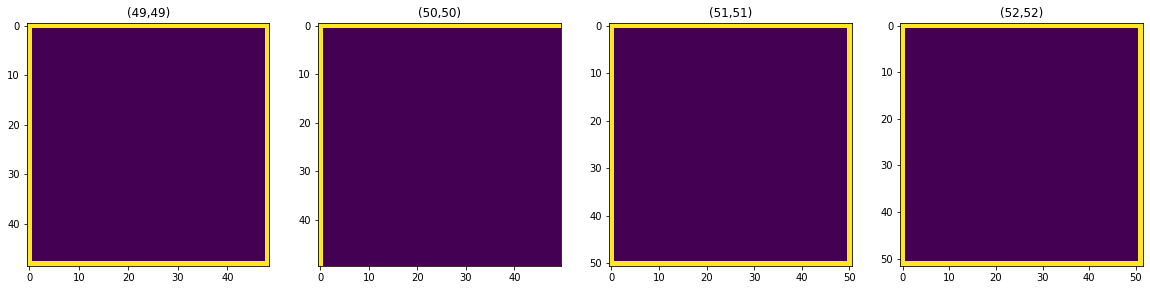

In [ ]:
def boundary(x,y, xlim = [0,L_s], ylim=[0,L_s]):
  ''' Returns 0 when at the boundary of Omega and 1 on the interior''' 
  ans=0
  if x in xlim or y in ylim:
  #if np.round(x,10) in xlim or np.round(y,10) in ylim: #<- fixed it with this round function
    ans = 1
  return ans

tmp_list = [49,50,51,52]
fig,axs=plt.subplots(1,tmp_list.__len__(),figsize=(5*tmp_list.__len__(),5))
for i,tmp in enumerate(tmp_list):
  axs[i].imshow(reshape(create(boundary,tmp,tmp),tmp,tmp))
  axs[i].title.set_text('(%i,%i)' %(tmp,tmp))

### Matrix creation
Creation of any matrix from stencil fromulation. Let the matrix $A_h$ be represented by the following stencil:
\begin{align*}
\begin{bmatrix}
  a_{00} & a_{01} & a_{02}\\
  a_{10} & a_{11}& a_{12} \\
  a_{20} & a_{21}& a_{22} \\
\end{bmatrix}_h=
\begin{bmatrix}
  a_{NW} & a_{N} & a_{NE}\\
  a_{W} & a_{\cdot}& a_{E} \\
  a_{SW} & a_{S}& a_{SE} \\
\end{bmatrix}_h
\end{align*}
Here the *numbers* indicate the python position in the matrix and the *letters* indicate the relative positoin of the element with respect to our current element. \\

In [ ]:
''' Create Ah from stencil  ''' 
def create_from_stencil(stencil,nx:int,ny:int):
  ''' Does not have -1 on the boundary! '''
  if stencil.ndim==1 and stencil.shape[0] == 3 and ny==1 :
    diags = [(stencil[0])*np.ones((1,nx-1)),stencil[1]*np.ones((1,nx)),(stencil[2])*np.ones((1,nx-1))]
    A = sp.diags(diags, [-1, 0, 1],shape=(nx,nx))
  # 2D 
  elif stencil.ndim==2 and stencil.shape[0] == 3 and  stencil.shape[1] == 3 :
      # to compensate for my oepsy
    diags = [
             stencil[2,0]*np.ones((1, nx*ny-nx-1 )), 
             stencil[2,1]*np.ones((1, nx*ny-nx )),   
             stencil[2,2]*np.ones((1, nx*ny-nx+1 )), 
             stencil[1,0]*np.ones((1, nx*ny-1 )),
             stencil[1,1]*np.ones((1, nx*ny )),
             stencil[1,2]*np.ones((1, nx*ny+1 )),
             stencil[0,0]*np.ones((1, nx*ny+nx-1 )),
             stencil[0,1]*np.ones((1, nx*ny+nx )),
             stencil[0,2]*np.ones((1, nx*ny+nx+1 ))]
    A = sp.diags(diags, [-nx-1,-nx,-nx+1,-1, 0, 1,nx-1,nx,nx+1],shape=(nx*ny,nx*ny))


  else:
     raise ValueError(' Wrong stencil dimensions  ') 
  return A

The system matrix is $K$ on the interior of $\Omega_i'$ and on the boundary  we will assing $[0\cdots 0\, 1\, 0 \cdots 0 ]$ a zero row with only one on the diagonal.
The boundaries are adressed using the following code:

In [ ]:
def boundary(x,y, xlim = [0,L_s], ylim=[0,L_s]):
  ''' Returns 0 when at the boundary of Omega and 1 on the interior''' 
  ans=0
  if np.round(x,10) in xlim or np.round(y,10) in ylim: #<- fixed it with this round function
    ans = 1
  return ans
  
def A_remove_boundary(A, nx:int = m_s+l_s, ny:int = m_s+l_s,bv = 1):

  ''' Boundary correction of A'''
  #needed variables
  exterior_vec = create(boundary,nx,ny)
  # plt.imshow(reshape(exterior_vec,nx,ny)) 
  # plt.show()
  
  where = sp.find(exterior_vec)[1]
  #where = np.where(exterior_vec==1)[0]


  N=nx*ny # total amount of elements in matrix A

  # sparse version of A
  B2 = sp.csr_matrix(A)
  B2.eliminate_zeros()
    


  B = sp.csr_matrix(sp.eye(A.shape[0]))
    
  B2.eliminate_zeros()

  for w in where:
      B2[w,:] = bv*B[w,:]

  B2.eliminate_zeros() # regain some sparcity
    
  return B2

## def $\Omega\texttt{-list}$

To identify each subdomain $\Omega_i$ with ones we assign 1 everywhere on $\Omega$ as follows:
\begin{align*} 
   \mathbb{1}_{\Omega_i}(x,y):=\cases{1 ,  \hspace{0.4cm} \text{ if } (x,y)\in \Omega_i \\ 0 , \hspace{0.4cm} \text{ if } (x,y) \not\in \Omega_i}
\end{align*}. \\
A vector is created form this continous function using the ealier defined function `create(func,nx,ny)`.

The data is a stored in a ` list ` such that 
\begin{align*}
  \Omega \, \texttt{-list}=\left\{ \mathbb{1}_{\Omega_1} , \mathbb{1}_{\Omega_2} , \cdots, \mathbb{1}_{\Omega_N} \right\}.
\end{align*} \\

***`->` Note:***   
*    $\mathbb{1}_{\Omega_i}\in \mathbb{R}^{km\times km}$
*   and that we did not yet add the **interfaces**.

In [ ]:
' Lets define \Omega_i '

def omega_i(x,y,xlim,ylim):
  ans = 0
  if xlim[0] <= x and x <= xlim[1] and ylim[0] <= y and y <= ylim[1]:
    ans = 1
  return ans

''' To store them all let's make a list of all of our sub domains '''
Omega_list = []

''' loop over all k in both directions to create the whole list of sub domains '''
for i in range(k_s): 
  for j in range(k_s):
    tmp = L_s/k_s # the subdomain spacing

    def func(x,y): # a anoynamous function to overcome the numpy say no-no to if statements
      return omega_i(x, y, xlim = [tmp*i,tmp*(i+1)] , ylim = [tmp*j,tmp*(j+1)] )

    Omega_list.append(create(func,k_s*m_s,k_s*m_s))
    


### test plot  $\Omega\texttt{-list}$
To show that all $\Omega_i$ assamble $\Omega$ and to show the order in what the $\Omega\texttt{-list}$ is stored we create a **video**. 🎥 

*   **TIP**: Use the slider of the video to look at each immage seperatly

' \nDear lord, \nI pray to you to fuckingly please explain why the fuck this image below is shown. \nIn advanche I thank you. \n'

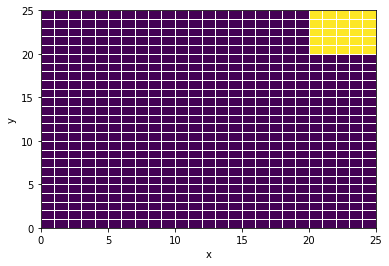

In [ ]:
' Lets plot omega_i '
fig, ax = plt.subplots(); 
ax.set_xlabel('x');
ax.set_ylabel('y');

ims = []
for i,view in enumerate(Omega_list):
    im = plt.pcolormesh(
      reshape(view,k_s*m_s,k_s*m_s)
      , edgecolors='w');
    ims.append([im]); 
  
''' 
Dear lord, 
I pray to you to fuckingly please explain why the fuck this image below is shown. 
In advanche I thank you. 
'''

In [ ]:
# creation of the video object
video = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

HTML(video.to_html5_video()) # create a viewable video in google colab

## extended  $\Omega'\texttt{-list}$ 
Let's  extend $ \Omega_i $ to $ \Omega_i '$. 

We currently have a list of all $\mathbb{1}_{\Omega_i}$ vectors. We want to expand these to  $\mathbb{1}_{\Omega_i'}$. This is trivial for the interior point but for the boundary points there are allot for variantions. 

How I solved it.


1.   Use the linear expansion opperator to create it.
\begin{align*}\mathbb{1}_{\Omega_i'}=
\left(
\begin{bmatrix}
  1 &  1 &  1 \\
  1 &  0 & 1 \\
  1 &  1 & 1 \\
\end{bmatrix}_h\right)^l \mathbb{1}_{\Omega_i}.
\end{align*}
2.   This is works and all but it gets screwed for the boundaries by the boundary conditions. So, to prefent any interaction the whole system is boxed in a extra boundary and set fixed to 0 on that new additional boundary. 
3.  But now on the expanded parts it hase non-one values. So we need to set all non-zero values back to 1 to create the propper $\mathbb{1}_{\Omega_i'}$.

In [ ]:
if False:
  '''  Test function with plots for understanding'''
  s_test = np.array([
                    [1,1,1],
                    [1,0,1],
                    [1,1,1]
                    ])

  tmp = Omega_list[4]
  plt.figure()
  plt.pcolormesh(
      reshape(tmp,k_s*m_s,k_s*m_s)
      , edgecolors='w', linewidth=2)
  ax = plt.gca();ax.set_aspect('equal')

  tmp = reshape(tmp,k_s*m_s,k_s*m_s)
  tmp = np.c_[ np.zeros(k_s*m_s), tmp , np.zeros(k_s*m_s) ] 
  tmp = np.r_[ np.zeros((1,k_s*m_s+2)),tmp, np.zeros((1,k_s*m_s+2)) ] 
  tmp = np.reshape( tmp , ((k_s*m_s+2)*(k_s*m_s+2),))

  plt.figure()
  plt.pcolormesh(
      reshape(tmp,k_s*m_s+2,k_s*m_s+2)
      , edgecolors='w', linewidth=2)
  ax = plt.gca();ax.set_aspect('equal')

  A_tmp = create_from_stencil(s_test , k_s*m_s+2,k_s*m_s+2 )
  #A_tmp = A_remove_boundary(A_tmp,k_s*m_s+2,k_s*m_s+2,1)
  tmp = A_tmp*tmp


  plt.figure()
  plt.pcolormesh(
      reshape(tmp,k_s*m_s+2,k_s*m_s+2)
      , edgecolors='w', linewidth=2)
  ax = plt.gca();ax.set_aspect('equal')
      
      

  img = np.zeros((k_s*m_s+2)*(k_s*m_s+2))
  for q in np.where(tmp!=0)[0]:
    img[q] = 1 

  plt.figure()
  plt.pcolormesh(
      reshape(img,k_s*m_s+2,k_s*m_s+2)[1:-1,1:-1]
      , edgecolors='w', linewidth=2)
  ax = plt.gca();ax.set_aspect('equal')

In [ ]:
def Omega_i_expansion(Omega_i, l:int = l_s):
  ''' This code expands a indicator function by 1 , l times. ''' 
  # initialize the tmp train
  tmp = Omega_i
  tmp_N = int(np.sqrt(Omega_i.shape[0])) # get the lenght of the 2D array
  
  # step 2: 
  ''' To not have to deal with the boundary we box the whole system in.  '''
  tmp = reshape(tmp,tmp_N,tmp_N)                                   # to 2D 
  tmp = np.c_[ np.zeros(tmp_N), tmp , np.zeros(tmp_N) ]            # Add two colmuns 
  tmp = np.r_[ np.zeros((1,tmp_N+2)),tmp, np.zeros((1,tmp_N+2)) ]  # Add two rows
  tmp = np.reshape( tmp , ((tmp_N+2)*(tmp_N+2),))                  # back to lexico

  #step 1:
  ''' The creation of the extention matrix '''
  A_expansion = create_from_stencil(
                np.array([    [1,1,1],  # The extention stencil
                              [1,0,1],  #
                              [1,1,1] ])#
                , tmp_N+2,tmp_N+2 ) 
  
  A_expansion = A_remove_boundary(A_expansion,k_s*m_s+2,k_s*m_s+2,1)

  ''' for each l we repeat the expansion''' 
  for i in range(l):
    tmp = A_expansion*tmp

  # This function is not all ones  

  # step 3
  ''' creation of a indicator function '''
  img = np.zeros((tmp_N+2)*(tmp_N+2))
  for q in np.where(tmp!=0)[0]:
    img[q] = 1 

  # undo step 2.
  ''' Return back withouth the added rows and columns ''' 
  ans = reshape(img,tmp_N+2,tmp_N+2)[1:-1,1:-1] # back to 2D 
  ans = np.reshape( ans , ((tmp_N)*(tmp_N),))   # back to lex
  return ans

In [ ]:
''' Here we assign to our now Omega_tilde_list ''' 
Omega_tilde_list = Omega_list.copy()

for i, crt_Omega in enumerate(Omega_list):

  Omega_tilde_list[i] = Omega_i_expansion(Omega_list[i])

C:\Users\billy\Anaconda3\lib\site-packages\scipy\sparse\_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


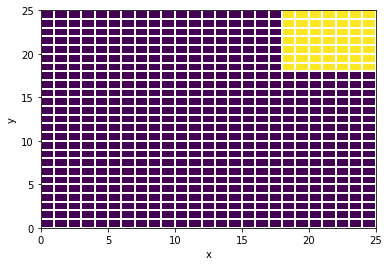

In [ ]:
' Lets plot omega_i '
fig, ax = plt.subplots();
ax.set_xlabel('x');
ax.set_ylabel('y');

ims = []
for i,view in enumerate(Omega_tilde_list):

    im = plt.pcolormesh(
      reshape(Omega_tilde_list[i],k_s*m_s,k_s*m_s)
      , edgecolors='w', linewidth=2);
    ims.append([im]);
  
  # creation of the video object
video = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                  repeat_delay=1000);

HTML(video.to_html5_video()) # create a viewable video in google colab

Now let's  create $R_i$ the **restriction** /  **extention** operators.

Ri has shape =  (49, 625)


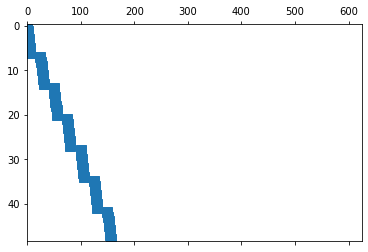

In [ ]:
def extractor(indices, N):
   indptr=np.arange(len(indices)+1)
   data=np.ones(len(indices))
   shape=(len(indices),N)
   return sp.csr_matrix((data,indices,indptr), shape=shape)

print('Ri has shape = ' , extractor(np.where(Omega_tilde_list[0] == 1)[0],(k_s*m_s)**2).shape)

if True:
  plt.figure();plt.spy(extractor(np.where(Omega_tilde_list[0]==1)[0],(k_s*m_s)**2),aspect = 'auto')

## Creation of $K$

The system matrix $K$ should discretize the $-\Delta = -\nabla^2$ using $B_{i}^1(x)B_j^1(y)$ as test functions. We have already seen this thousands of times the discretized stencil form of $\Delta$ is given by 
\begin{align*}
K=\frac{1}{3h^2}\begin{bmatrix}
  -1 & -1 & -1\\
  -1 & 8 & -1 \\
  -1 & -1 & -1 \\
\end{bmatrix}_h
\end{align*}

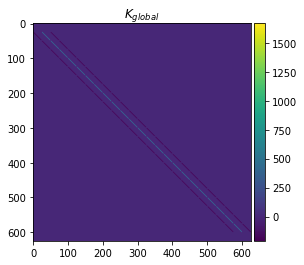

In [ ]:
''' Definting K ''' 
s_K = 1/3*(L_s/(m_s*k_s))**(-2)*np.array([
                   [-1,-1,-1],
                   [-1,8,-1],
                   [-1,-1,-1]
                   ])



K_global = A_remove_boundary(create_from_stencil(s_K , k_s*m_s, k_s*m_s ),k_s*m_s,k_s*m_s)

if True:
  fig, (ax) = plt.subplots(1,1)
  im = plt.imshow(K_global.toarray())
  plt.title('$K_{global}$')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  CBI = fig.colorbar(im, cax=cax)

## Iteration 
The Dirichlet problem we need to solve subdomian by subdomain is given by:
\begin{align*}(D_i)
\begin{cases}
-\nabla^2 u^{n+\frac{i}{N}}&=f \hspace{1cm} &\text{ in } \Omega_i',\\
u^{n+\frac{i}{N}}=&u^{n+(i-1)/N}  & \text{on } \partial \Omega_i',\\
u^{n+\frac{i}{N}}=&u^{n+\frac{i-1}{N}} & \text{on } \left(\cup_{j=1,\cdots,N} \Omega_j'\right) \setminus \overline{ \Omega_i' }.
\end{cases}
\end{align*}

I think that the notation $u^{n+\frac{i}{N}}$ is a bit strange and I suggest the use of the following notation $u^n_{i}$ or $u^{n_i}$ where $n$ denotes the global iteration steps and $i\in{1,\cdots, N}$ the current subdomain we are working on.  With this simplified notation the problem becomes:
\begin{align*}(D_i)
\begin{cases}
-\nabla^2 u^{n}_i&=f \hspace{1cm} &\text{ in } \Omega_i',\\
u^{n}_i=&u^{n}_{i-1}  & \text{on } \partial \Omega_i',\\
u^{n}_i=&u^{n}_{i-1} & \text{on } \left(\cup_{j=1,\cdots,N} \Omega_j'\right) \setminus \overline{ \Omega_i' }.
\end{cases}
\end{align*}


### The forcing $f$.

The forcing in given by $f(x,y)=2(x(1-x)+y(1-y))$.

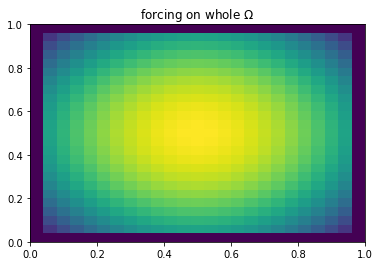

In [ ]:
def forcing(x,y):
  return 2*x*(1-x)+2*y*(1-y)

forcing_vec = (np.ones((m_s*k_s*m_s*k_s))-create(boundary,k_s*m_s,k_s*m_s))*create(forcing,k_s*m_s,k_s*m_s)

if True:
  plt.figure();plt.title(r'forcing on whole $\Omega$');plt.imshow(reshape(forcing_vec,k_s*m_s,k_s*m_s),aspect='auto',extent=[0,1,0,1])

### Without elimination of boundary conditions

 we get the following problem: 
\begin{align*}
K_i u^{n}_i&=f_i +u^{b.c.}_{i-1}.
\end{align*}

### initial geuss
We again use the data structure of the $\Omega\texttt{-list}$ to create the data structure for the solutions $u^n_i \ \forall i \in \{1,\cdots,N\}$. \\
The curent data strcutre is a  ``` list ``` such that 
\begin{align*}
  u^n \, \texttt{-list}=\left\{ u^n_1, u^n_2 , \cdots, u^n_N \right\}.
\end{align*}
Note that each $u_1^n\in \mathbb{R}^{(m+l)\times (m+l)}$ thus this is a list of arrays. 

In [ ]:
''' Initial guess '''

u_IC =  (np.ones(((m_s*k_s)**2))-create(boundary,m_s*k_s,m_s*k_s))*np.random.rand((m_s*k_s)**2)*0

if False:
  plt.figure()
  plt.title(r'$u_{i.c.}$')
  plt.imshow( reshape( u_IC,m_s*k_s,m_s*k_s), extent=[0,1,0,1])

u_list = []


for i, view in enumerate(Omega_tilde_list):
  Ri = extractor( np.where(view == 1)[0], N = (k_s*m_s)**2 )
  u_list.append(Ri*u_IC)
  
u_list_n= u_list.copy()

### The LOOP ` <- `


Things to do in one domain loop
1.   Create $R_i:\Omega\to\Omega_i$
2.   Find the 2D structure of $u_i^n$
3.   Create the forcing imposed via the other elements
4.   Create $K$ in correct shape `<- can be pre-computed`
5.   Solve







 |n= 0 	 | i= 0 	 | e = 42.0000 

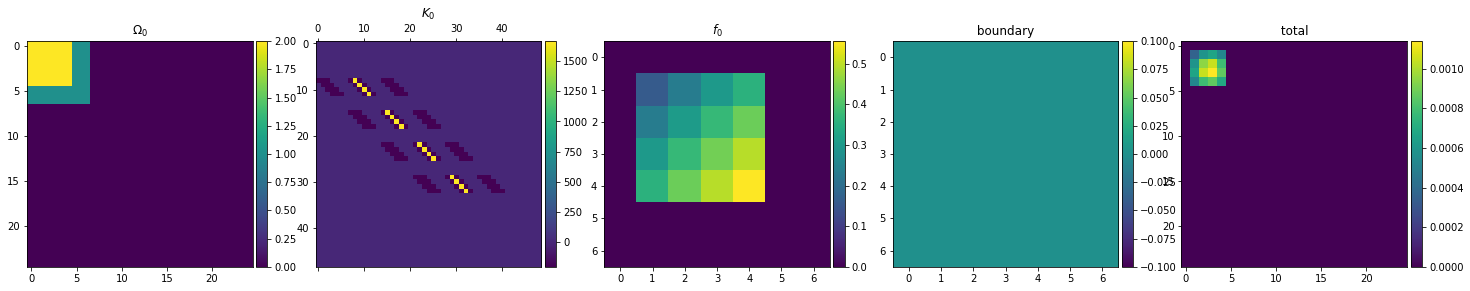

 |n= 0 	 | i= 1 	 | e = 42.0000 

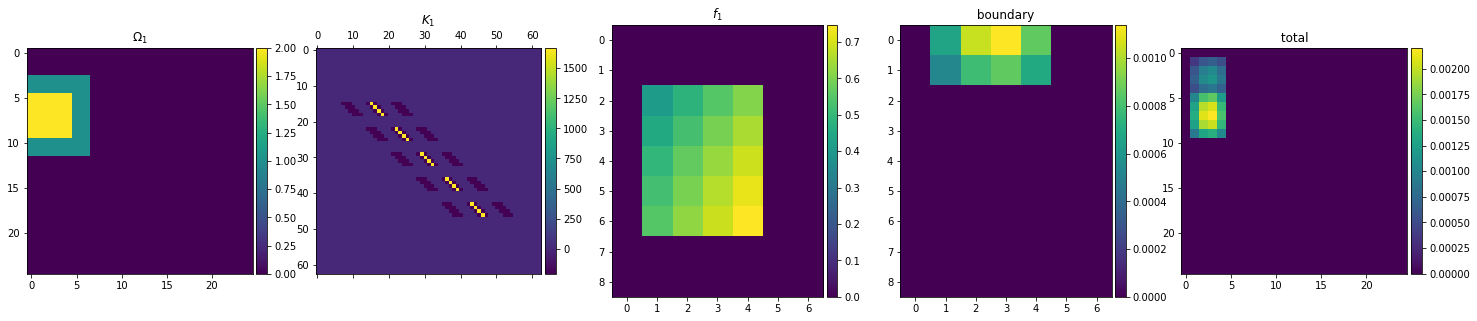

 |n= 0 	 | i= 2 	 | e = 42.0000 

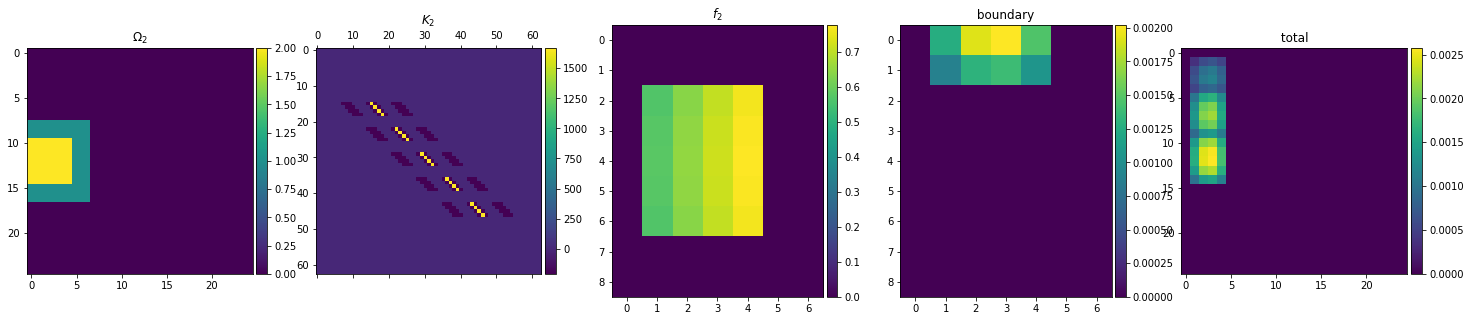

 |n= 0 	 | i= 3 	 | e = 42.0000 

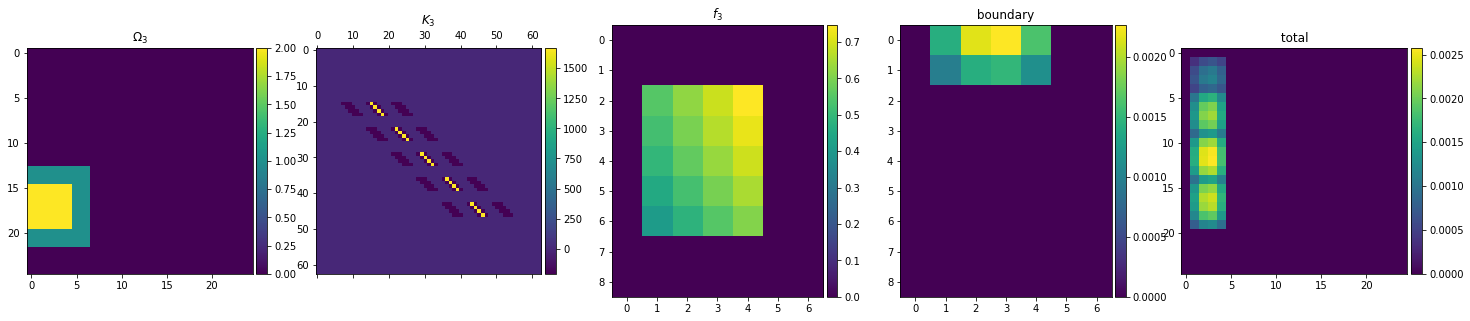

 |n= 0 	 | i= 4 	 | e = 42.0000 

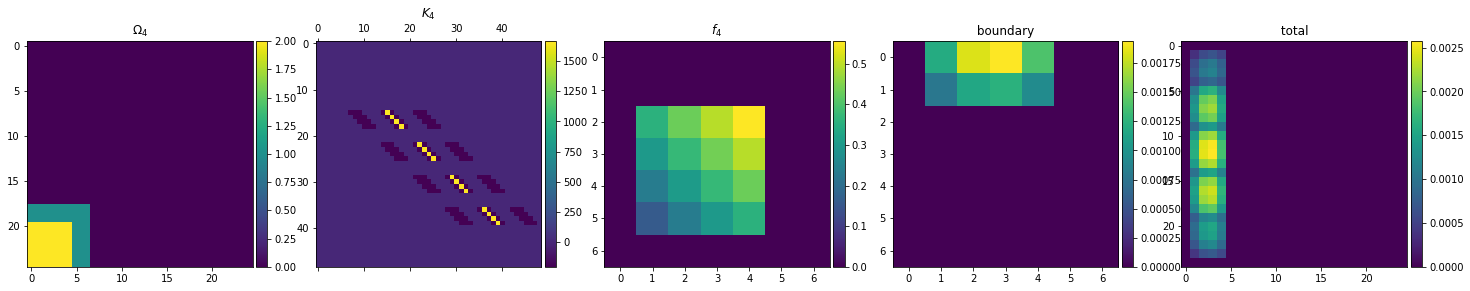

 |n= 0 	 | i= 5 	 | e = 42.0000 

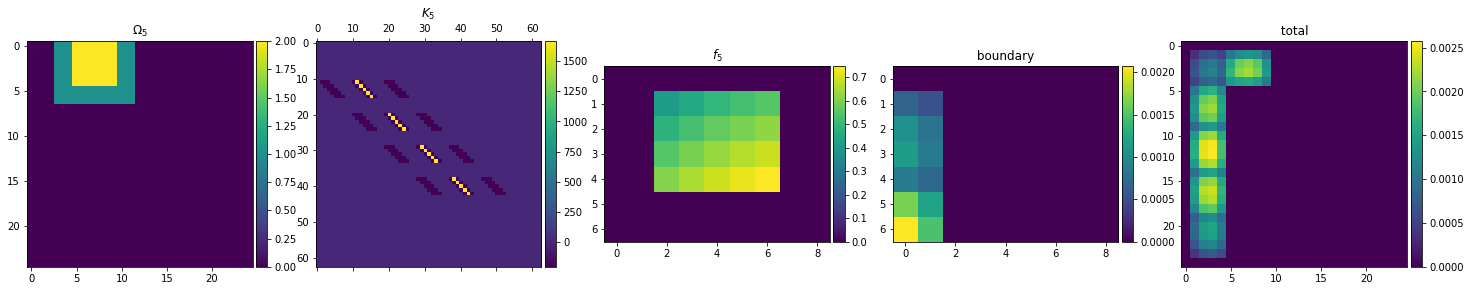

 |n= 0 	 | i= 6 	 | e = 42.0000 

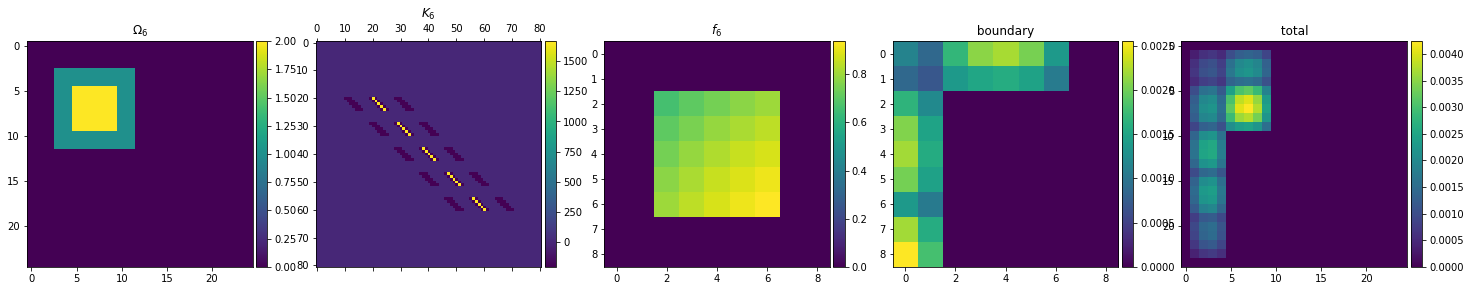

 |n= 0 	 | i= 7 	 | e = 42.0000 

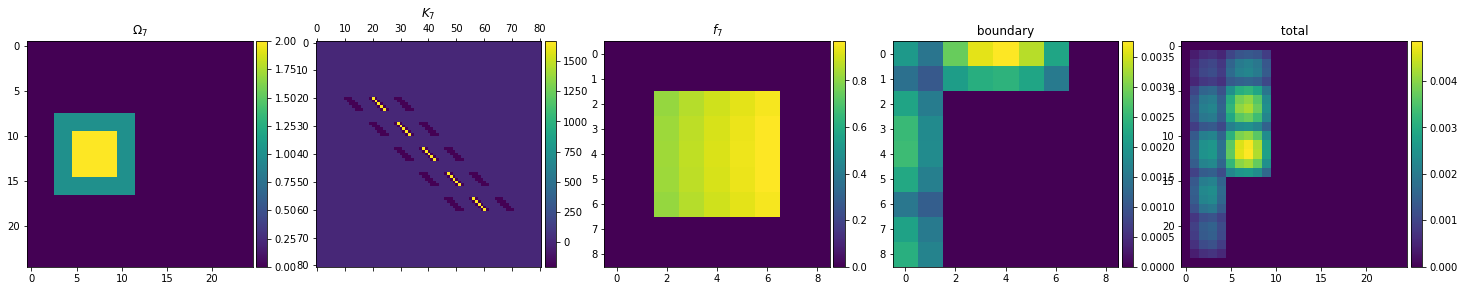

 |n= 0 	 | i= 8 	 | e = 42.0000 

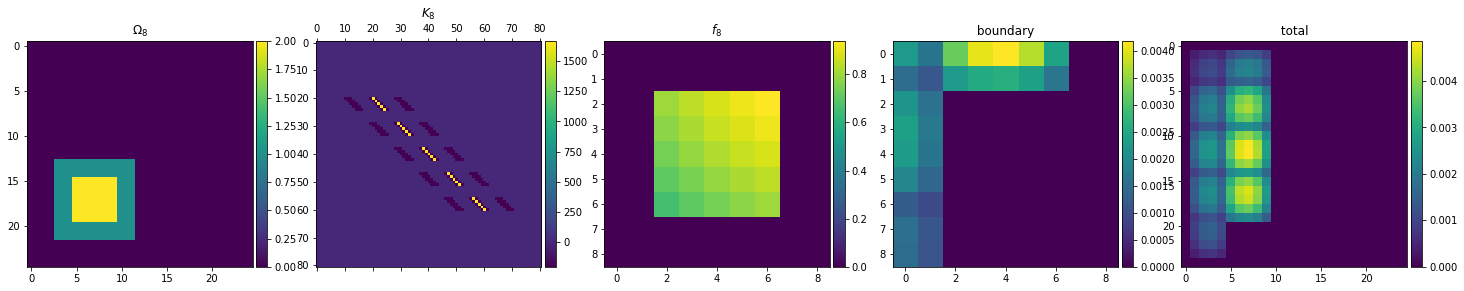

 |n= 0 	 | i= 9 	 | e = 42.0000 

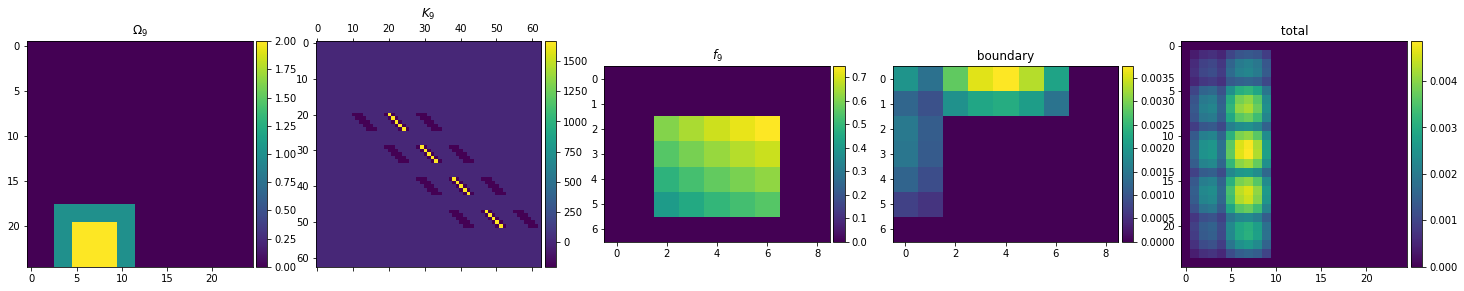

 -- loop forcestoped -- at n = 1010 n= 1 	 | i= 23 	 | e = 42.0000  |n= 4 	 | i= 20 	 | e = 42.0000  |n= 7 	 | i= 9 	 | e = 42.0000  |n= 10 	 | i= 1 	 | e = 42.0000  |n= 13 	 | i= 19 	 | e = 42.0000  |n= 17 	 | i= 3 	 | e = 42.0000  |n= 19 	 | i= 17 	 | e = 42.0000  |n= 22 	 | i= 12 	 | e = 42.0000  |n= 26 	 | i= 8 	 | e = 42.0000  |n= 28 	 | i= 15 	 | e = 42.0000  |n= 31 	 | i= 7 	 | e = 42.0000  |n= 35 	 | i= 3 	 | e = 42.0000  |n= 37 	 | i= 14 	 | e = 42.0000  |n= 40 	 | i= 23 	 | e = 42.0000  |n= 44 	 | i= 2 	 | e = 42.0000  |n= 47 	 | i= 16 	 | e = 42.0000  |n= 50 	 | i= 4 	 | e = 42.0000  |n= 53 	 | i= 2 	 | e = 42.0000  |n= 56 	 | i= 17 	 | e = 42.0000  |n= 60 	 | i= 6 	 | e = 42.0000  |n= 63 	 | i= 9 	 | e = 42.0000  |n= 66 	 | i= 11 	 | e = 42.0000  |n= 69 	 | i= 0 	 | e = 42.0000  |n= 72 	 | i= 7 	 | e = 42.0000  |n= 75 	 | i= 11 	 | e = 42.0000  |n= 77 	 | i= 23 	 | e = 42.0000  |n= 81 	 | i= 7 	 | e = 42.0000  |n= 85 	 | i= 0 	 | e = 42.0000  |n= 88 	 | i= 4 	 | e = 42.0000

In [ ]:
print_bool=False # want a infinte amount of plots?

def loss():
  ''' A decent loss function'''

n=0 #loop counter
while True: #<- HERE COMES A LOSS/error/minimisation/gain FUNCTION 
  IMG = np.zeros(u_IC.shape) # creating the final solution
  #on current sub domain
  for i, crt_u in enumerate(u_list):
    ''' [1]  Obtain the extraction operator '''
    Ri_non_overlap = extractor( np.where(Omega_list[i] == 1)[0], N = (k_s*m_s)**2 )
    Ri = extractor( np.where(Omega_tilde_list[i] == 1)[0], N = (k_s*m_s)**2 )

    Global_Omega_i = Omega_list[i] 
    Global_Omega_i_tilde = Omega_tilde_list[i]

    ''' [2] We need to obtain the shape of the non extened Omega_i' '''
    tmp = np.reshape(Omega_tilde_list[i],(k_s*m_s,k_s*m_s))
      
    tmp = tmp[~np.all( tmp== 0, axis=1)]     # Honestly, I know it is ugly....
    tmp = tmp.T                              #  
    tmp = tmp[~np.all( tmp== 0, axis=1)]     # 
    tmp = tmp.T                              # ----------------------
    ui_shape = tmp.shape                     # <- We only need this   
    if print_bool: print(' u_i.shape=(%i,%i) , %i' %(ui_shape[0],ui_shape[0],ui_shape[0]*ui_shape[1]))
    if print_bool: print('Ri.shape = ',Ri.shape)


    ''' [3] create the boundary condition from the surrounding elements'''# look at the boundary of all 8 surrounding 
    # bc_forcing_vec = np.zeros(ui_shape[0]*ui_shape[1])
    # for k in [ -k_s-1, -k_s, -k_s+1, -1, 1, k_s-1, k_s, k_s+1 ]: 
    #   if print_bool: print('testing for k = %i' %(k))
    #   if not( i+k>Omega_tilde_list.__len__()) and not(i+k<0) and not(np.mod(i+k,k_s)==0):
    #     ''' Rj is a mapping from the neigbourh to whole mesh. '''
    #     Rj = extractor( np.where(Omega_tilde_list[i+k] == 1)[0], N = (k_s*m_s)**2 )
        
    #     ''' Note that when \Omega_i and \Omega_j do not neighbor thay have that Ri*Rj.T=zero '''
    #     
        # # plotting ally
        # if print_bool: print('Rj.shape = ',Rj.shape)
        # if print_bool: print('bc_forcing.shape = ', bc_forcing_vec.shape)

    bc_forcing_vec =  Ri*(IMG*(Global_Omega_i_tilde-Global_Omega_i))

    # plan: Change to GMRESS with precon| have the code would work much faster BUT|
    #       since we don't have a good system for beforhand knowing the dimensions of u 
    #       It would take allot to put that in right now
    ' [4] creation of K_i'  
    
    
    Ki = Ri*K_global*Ri.T
    Ki = sp.diags(Ri*Global_Omega_i,0)*Ki+sp.eye(ui_shape[1]*ui_shape[0])
    #Ki = A_remove_boundary( Ki,  ui_shape[1], ui_shape[0]) #<- can be pre-computed if we cr
    #extension_indices = Ri*Rj.T*np.arange(np.asarray(u_list).size)

    RHS_f = Ri*(Global_Omega_i*forcing_vec)

  

    
    ' [5] Solving '
    u_list[ i ] = la.spsolve( Ki ,RHS_f+bc_forcing_vec)
    

    print('\r |n= %i \t | i= %i \t | e = %.4f' %(n,i,42) , end=' ')

    if i<10 and n==0:
      fig, (ax0,ax1,ax2,ax3,ax4)=plt.subplots(1,5,figsize=(5*5,5))
      im = ax0.imshow(reshape(Omega_tilde_list[i]+Omega_list[i],k_s*m_s,k_s*m_s ))
      ax0.set_title('$\Omega_%i$' %(i))
      divider = make_axes_locatable(ax0)
      cax = divider.append_axes("right", size="5%", pad=0.05)
      CBI = fig.colorbar(im, cax=cax)
      im = ax1.matshow(Ki.toarray())
      ax1.set_title('$K_%i$' %(i))
      divider = make_axes_locatable(ax1)
      cax = divider.append_axes("right", size="5%", pad=0.05)
      CBI = fig.colorbar(im, cax=cax)
      im = ax2.imshow(reshape(RHS_f , ui_shape[1], ui_shape[0]  ))
      ax2.set_title('$f_%i$' %(i))
      divider = make_axes_locatable(ax2)
      cax = divider.append_axes("right", size="5%", pad=0.05)
      CBI = fig.colorbar(im, cax=cax)
      im= ax3.imshow(reshape( bc_forcing_vec, ui_shape[1], ui_shape[0] ))
      ax3.set_title(' boundary ')
      divider = make_axes_locatable(ax3)
      cax = divider.append_axes("right", size="5%", pad=0.05)
      CBI = fig.colorbar(im, cax=cax)

      IMG = IMG + Ri.T*(u_list[ i ] * (Ri*Global_Omega_i ))# stack all extened u's 

      ax4.set_title(' total ')
      im = ax4.imshow(reshape( IMG,m_s*k_s,m_s*k_s ))
      divider = make_axes_locatable(ax4)
      cax = divider.append_axes("right", size="5%", pad=0.05)
      CBI = fig.colorbar(im, cax=cax)
      plt.show()

  #u_list = u_list_n # remove the old 
  ''' in case infinte loop '''
  if n>100:
    print('-- loop forcestoped -- at n = %i' %(n))
    break
  else:
    n+=1

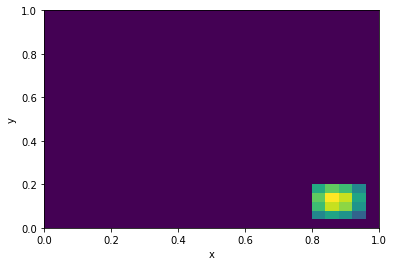

In [ ]:
' Lets plot omega_i '
fig, ax = plt.subplots();
ax.set_xlabel('x');
ax.set_ylabel('y');

ims = []
IMG = np.zeros((k_s*m_s*k_s*m_s))
for i,view in enumerate(u_list):
    Ri = extractor( np.where(Omega_list[i] == 1)[0], N = (k_s*m_s)**2 )
    Ri_tilde = extractor( np.where(Omega_tilde_list[i] == 1)[0], N = (k_s*m_s)**2 )

    IMG = IMG + Ri.T*Ri*Ri_tilde.T*view # stack all extened u's 

    ''' 
    For debuggin lets look at all sub domains.
    But Billy that takes wayyyy to long, No not if you use:
    ANIMATIONsss. 
                      ^o^
     '''  
    im = plt.imshow(
                       reshape(Ri_tilde.T*view,k_s*m_s,k_s*m_s)
                    ,aspect = 'auto',extent=[0,1,0,1]);
    ims.append([im]);

      # creation of the video object
video = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                  repeat_delay=1000)

HTML(video.to_html5_video()) # create a viewable video in google colab

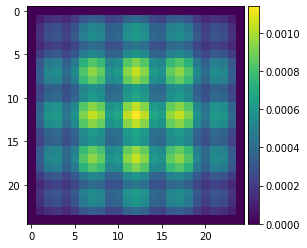

In [ ]:
''' Lets try to create the solution on the whole domain '''
fig , (ax) = plt.subplots(1,1)
ax.imshow(reshape(IMG,k_s*m_s,k_s*m_s))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
CBI = fig.colorbar(im, cax=cax)


## Getting the exact solution

Text(0.5, 1.0, 'exact solution')

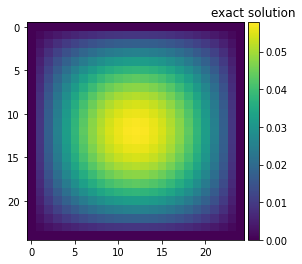

In [ ]:
''' Get the exact solution'''

uex = la.spsolve(K_global,forcing_vec)

''' Lets try to create the solution on the whole domain '''
fig, (ax) = plt.subplots(1,1)
im = ax.imshow(reshape(uex,k_s*m_s,k_s*m_s))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
CBI = fig.colorbar(im, cax=cax)

plt.title('exact solution')

Text(0.5, 1.0, 'error')

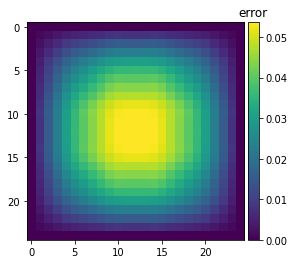

In [ ]:
''' Plot the error '''
fig, (ax) = plt.subplots(1,1)
im = ax.imshow(reshape(uex-IMG,k_s*m_s,k_s*m_s))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
CBI = fig.colorbar(im, cax=cax)
plt.title('error')